### Created by: Anthony D. Cho
### Last update: 20.11.2021

**Subject**: Regression (LSTM - keras, tensorflow) - Air Quality

**Tips**: Handling missing values through the model.

## Libraries dependencies

In [1]:
from time import time
from pandas import read_excel, concat
from numpy import nan, nan_to_num
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-processing
from sklearn.preprocessing import MinMaxScaler

## Models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## Customized functions

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

    @param width: width of the graphic display
    @type width: int

    @param height: height of the graphic display
    @type height: int

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()


def convertToLookbackFormat(data, lookback=0):
    """
        DESCRIPTION:
            Convert data to include lookback samples
        
        INPUT:
            @param data: set of signals in dataframe format
            @type data: pandas.DataFame
            
            @param lookback: number of samples to lookback from time t (excluding sample at time t)
            @type lookback: int
        
        OUTPUT:
            @param data: lookback-format dataframe
            @type data: pandas.DataFame
    """
    
    df = []
    for s in range(lookback, -1, -1):
        df.append( data.shift(s) )
    df = concat(df, axis=1).dropna()
    
    ## return signals as Dataframe
    return df

# Problem: Air Quality

**Target**: Estimate the averaged concentration CO (Carbon monoxide) - variable CO(GT) - in 24 hours

## Data loading
Source: [Air Quality](https://archive.ics.uci.edu/ml/datasets/Air+quality#) (UCI Repository)

In [3]:
## Download and uncompress .zip file
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
!unzip AirQualityUCI.zip

--2021-12-03 22:48:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1543989 (1.5M) [application/x-httpd-php]
Saving to: ‘AirQualityUCI.zip’

AirQualityUCI.zip   100%[===================>]   1.47M  7.57MB/s    in 0.2s    

2021-12-03 22:48:04 (7.57 MB/s) - ‘AirQualityUCI.zip’ saved [1543989/1543989]

Archive:  AirQualityUCI.zip
  inflating: AirQualityUCI.csv       
  inflating: AirQualityUCI.xlsx      


In [4]:
## Loading data set
data_raw = read_excel("AirQualityUCI.xlsx")

## replace missing value (value: -200) with nan
#data_raw.replace(to_replace=-200, value=nan, inplace=True)

## Data shapes
print('Shape (data): {}'.format(data_raw.shape))

Shape (data): (9357, 15)


In [5]:
## Display dataset
data_raw.head(4)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.9,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.0,60.000000,0.786713


In [6]:
## Sample per hour
data_raw.iloc[[0, 24]]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.5,166.0,1056.25,113.0,1692.0,1267.5,13.60,48.875001,0.757754
24,2004-03-11,18:00:00,4.8,1580.75,307,20.799217,1318.5,281.0,798.50,151.0,2083.0,1408.5,10.35,64.174999,0.806544


In [7]:
data_raw.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357,9357,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
unique,391,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2004-09-07 00:00:00,10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,24,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2004-03-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2005-04-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
std,NaN,NaN,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670
min,NaN,NaN,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,NaN,NaN,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275


In [8]:
## Drop datetime columns
data = data_raw.drop(columns=['Date', 'Time'])
data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


### Data pre-processing

In [9]:
## Lookback format conversion
lookback = 1
lookback_data = convertToLookbackFormat(data, lookback=lookback)

## Replace miising label (-200) with nan
lookback_data.replace(to_replace=-200, value=nan, inplace=True)
lookback_data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
1,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600000,48.875001,0.757754,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300000,47.700000,0.725487,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900000,53.975000,0.750239,2.2,1375.50,80.0,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2.2,1375.50,80.0,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000000,60.000000,0.786713,1.6,1272.25,51.0,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
5,1.6,1272.25,51.0,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150000,59.575001,0.788794,1.2,1197.00,38.0,4.741012,750.25,89.0,1336.50,96.0,1393.00,949.25,11.175,59.175000,0.784772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.9,1296.50,NaN,13.552393,1102.00,522.7,506.75,186.5,1375.25,1582.50,18.150001,36.275001,0.748652,3.1,1314.25,NaN,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,3.1,1314.25,NaN,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850000,29.250000,0.756824,2.4,1162.50,NaN,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2.4,1162.50,NaN,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325000,23.725000,0.711864,2.4,1142.00,NaN,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2.4,1142.00,NaN,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900000,18.350000,0.640649,2.1,1002.50,NaN,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [10]:
## delay size
delay = 24  ## --> Look for the next day at the same hour

## Predictors and target
X = lookback_data.iloc[:-delay, :]
y = lookback_data.iloc[delay:, 13*lookback]

## display data format
print('Shape X: {}'.format(X.shape))
print('Shape y: {}'.format(y.shape))

## 2-Partition: Train, and test
X_train, y_train = X.iloc[:-100, :], y.iloc[:-100]
X_test, y_test = X.iloc[-100:, :], y.iloc[-100:]

## display data format
print('(train) Shape X: {}, Shape y: {}'.format(X_train.shape, y_train.shape))
print('(test) Shape X: {}, Shape y: {}'.format(X_test.shape, y_test.shape))

Shape X: (9332, 26)
Shape y: (9332,)
(train) Shape X: (9232, 26), Shape y: (9232,)
(test) Shape X: (100, 26), Shape y: (100,)


In [11]:
## Scaler instances
X_scale = MinMaxScaler().fit(X_train)
y_scale = MinMaxScaler().fit(y_train.values.reshape(-1,1))

## scaling trasform
X_train2, y_train2 = X_scale.transform(X_train), y_scale.transform(y_train.values.reshape(-1,1))
X_test2, y_test2 = X_scale.transform(X_test), y_scale.transform(y_test.values.reshape(-1,1))

## Missing value assignment, replace nan with -1
X_train2 = nan_to_num(X_train2, nan=-1)
y_train2 = nan_to_num(y_train2, nan=-1).flatten()

X_test2 = nan_to_num(X_test2, nan=-1)
y_test2 = nan_to_num(y_test2, nan=-1).flatten()

## Reshape to RNN tensors
X_train2 = X_train2.reshape(( len(X_train2) , -1, 13))
X_test2 = X_test2.reshape(( len(X_test2) , -1, 13))

## display data format
print('(train) Shape X: {}, Shape y: {}'.format(X_train2.shape, y_train2.shape))
print('(test) Shape X: {}, Shape y: {}'.format(X_test2.shape, y_test2.shape))

(train) Shape X: (9232, 2, 13), Shape y: (9232,)
(test) Shape X: (100, 2, 13), Shape y: (100,)


## Model building

In [12]:
## Model instance
model = Sequential(name='AirQuality')
model.add(layers.LSTM(units=10, input_shape=X_train2.shape[1:],
                      kernel_regularizer=l2(0.0001),
                      return_sequences = True,
                      name='LSTM_01'))
model.add(layers.LSTM(units=25,
                      kernel_regularizer=l2(0.0001), name='LSTM_02'))
model.add(layers.Dense(units=1,
                       name='Output'))

## Compiler settings
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mae', 
              metrics=['mse'])

## Display model
model.summary()

Model: "AirQuality"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_01 (LSTM)              (None, 2, 10)             960       
                                                                 
 LSTM_02 (LSTM)              (None, 25)                3600      
                                                                 
 Output (Dense)              (None, 1)                 26        
                                                                 
Total params: 4,586
Trainable params: 4,586
Non-trainable params: 0
_________________________________________________________________


In [13]:
## Fit model
start = time()
history = model.fit(x=X_train2, y=y_train2, 
                    validation_split=0.10,
                    shuffle=False,
                    epochs=30, 
                    batch_size=30)
print('\nTime spent[s]: ', time()-start)

Epoch 1/30
277/277 [==============================] - 7s 10ms/step - loss: 0.3189 - mse: 0.2384 - val_loss: 0.1126 - val_mse: 0.0434
Epoch 2/30
277/277 [==============================] - 2s 7ms/step - loss: 0.2947 - mse: 0.2476 - val_loss: 0.1017 - val_mse: 0.0401
Epoch 3/30
277/277 [==============================] - 2s 7ms/step - loss: 0.2888 - mse: 0.2424 - val_loss: 0.0983 - val_mse: 0.0385
Epoch 4/30
277/277 [==============================] - 2s 7ms/step - loss: 0.2842 - mse: 0.2347 - val_loss: 0.0960 - val_mse: 0.0373
Epoch 5/30
277/277 [==============================] - 2s 6ms/step - loss: 0.2806 - mse: 0.2277 - val_loss: 0.0945 - val_mse: 0.0363
Epoch 6/30
277/277 [==============================] - 2s 7ms/step - loss: 0.2780 - mse: 0.2213 - val_loss: 0.0939 - val_mse: 0.0355
Epoch 7/30
277/277 [==============================] - 1s 5ms/step - loss: 0.2759 - mse: 0.2159 - val_loss: 0.0937 - val_mse: 0.0350
Epoch 8/30
277/277 [==============================] - 1s 5ms/step - loss: 0

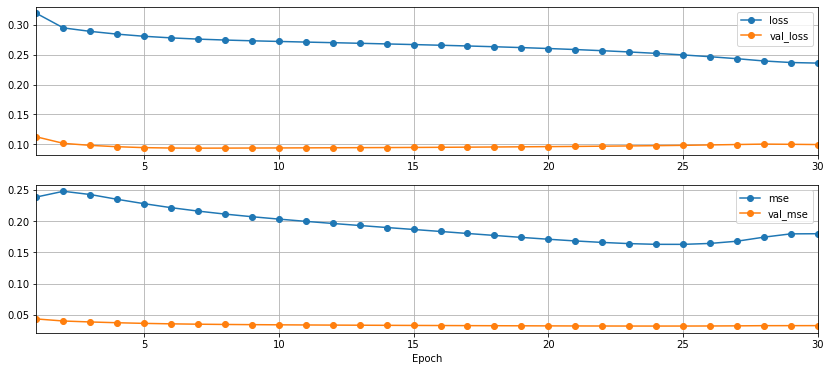

4/4 [==============================] - 0s 4ms/step - loss: 0.0832 - mse: 0.0298


[0.08323103189468384, 0.029846947640180588]

In [14]:
## Display performances
plot_history(history, width=14)

## Compute prediction with test set
model.evaluate(X_test2, y_test2)

In [15]:
## Compute prediction using test set
prediction = model.predict(X_test2)

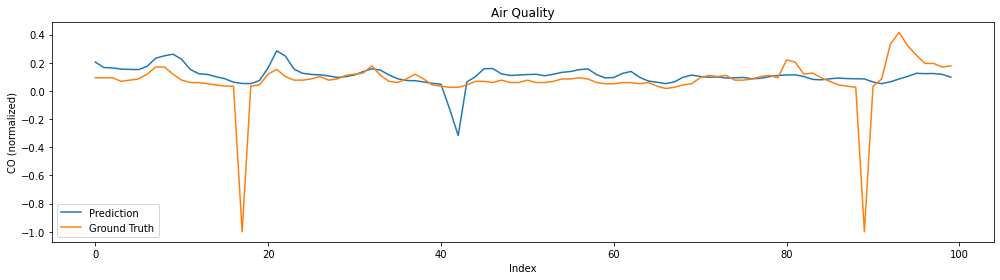

In [16]:
## Prediction and ground truth display
plt.figure(figsize=(14, 4))

plt.plot(prediction, label='Prediction')
plt.plot(y_test2, label='Ground Truth')
plt.xlabel('Index'); plt.ylabel('CO (normalized)')
plt.title('Air Quality')
plt.legend()
plt.tight_layout()
plt.show()

## Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 10.

In [17]:
## Model instance
model = Sequential(name='AirQuality')
model.add(layers.LSTM(units=10, input_shape=X_train2.shape[1:],
                      kernel_regularizer=l2(0.0001),
                      return_sequences = True,
                      name='LSTM_01'))
model.add(layers.LSTM(units=25,
                      kernel_regularizer=l2(0.0001), name='LSTM_02'))
model.add(layers.Dense(units=1,
                       name='Output'))

## Compiler settings
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mae', 
              metrics=['mse'])

## Display model
model.summary()

Model: "AirQuality"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_01 (LSTM)              (None, 2, 10)             960       
                                                                 
 LSTM_02 (LSTM)              (None, 25)                3600      
                                                                 
 Output (Dense)              (None, 1)                 26        
                                                                 
Total params: 4,586
Trainable params: 4,586
Non-trainable params: 0
_________________________________________________________________


In [18]:
## Fit model
start = time()
history = model.fit(x=X_train2, y=y_train2, 
                    shuffle=False,
                    epochs=10, 
                    batch_size=30)
print('\nTime spent[s]: ', time()-start)

Epoch 1/10
308/308 [==============================] - 6s 5ms/step - loss: 0.2967 - mse: 0.2315
Epoch 2/10
308/308 [==============================] - 2s 6ms/step - loss: 0.2823 - mse: 0.2332
Epoch 3/10
308/308 [==============================] - 2s 7ms/step - loss: 0.2744 - mse: 0.2231
Epoch 4/10
308/308 [==============================] - 2s 5ms/step - loss: 0.2675 - mse: 0.2116
Epoch 5/10
308/308 [==============================] - 2s 7ms/step - loss: 0.2617 - mse: 0.2006
Epoch 6/10
308/308 [==============================] - 2s 6ms/step - loss: 0.2572 - mse: 0.1912
Epoch 7/10
308/308 [==============================] - 2s 6ms/step - loss: 0.2540 - mse: 0.1835
Epoch 8/10
308/308 [==============================] - 2s 7ms/step - loss: 0.2516 - mse: 0.1772
Epoch 9/10
308/308 [==============================] - 1s 5ms/step - loss: 0.2497 - mse: 0.1719
Epoch 10/10
308/308 [==============================] - 2s 7ms/step - loss: 0.2480 - mse: 0.1674

Time spent[s]:  24.02444577217102


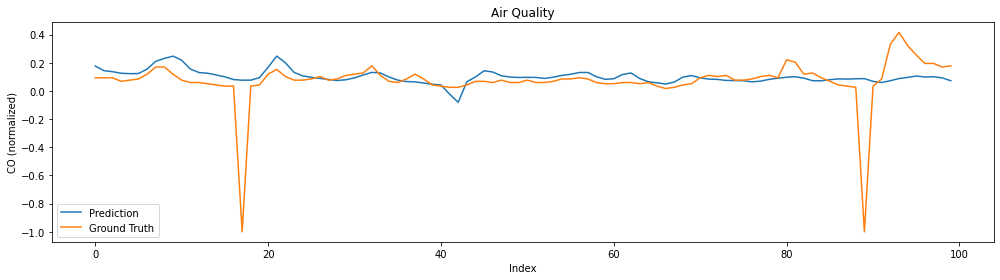

In [19]:
## Compute prediction using test set
prediction = model.predict(X_test2)

## Prediction and ground truth display
plt.figure(figsize=(14, 4))

plt.plot(prediction, label='Prediction')
plt.plot(y_test2, label='Ground Truth')
plt.xlabel('Index'); plt.ylabel('CO (normalized)')
plt.title('Air Quality')
plt.legend()
plt.tight_layout()
plt.show()